## phase 1

## II.2. Signal Generation

In [161]:
import numpy as np  
import matplotlib.pyplot as plt  
from typing import Tuple  

SAMPLE_RATE = 10000  
DURATION_SEC = 5.0   
NUM_SAMPLES = int(SAMPLE_RATE * DURATION_SEC)  
SAMPLE_INTERVAL_SEC = 1 / SAMPLE_RATE    

ADC_RESOLUTION = 12  
ADC_MAX_VALUE = 2**ADC_RESOLUTION - 1  
ENOB = 8  
SNR_DB = 6.02 * ENOB + 1.76  

DC_DRIFT_PERCENT = 0.05  
FREQ_DRIFT_PERCENT = 0.01  

DC_OFFSET_MIN = 1300.0  
DC_OFFSET_MAX = 2100.0  

AMPLITUDE_MIN = 300.0  
AMPLITUDE_MAX = 700.0  
AMPLITUDE_VARIATION_PERCENT = 0.05  

RANDOM_SEED = 1383  
np.random.seed(RANDOM_SEED)  

def generate_test_signal(  
    f_base: float,  
    duration_sec: float,  
    sample_rate: int,  
    initial_dc_offset: float,  
    dc_drift_per_sec: float,  
    amplitude: float,  
    amplitude_variation: float,  
    freq_drift_percent: float,  
    snr_db: float  
) -> Tuple[np.ndarray, np.ndarray]:  
    num_samples = int(sample_rate * duration_sec)  
    t = np.linspace(0, duration_sec, num_samples, endpoint=False)  

    f_end = f_base * (1 + freq_drift_percent * duration_sec)  
    f_slope = (f_end - f_base) / duration_sec  
    phase = 2 * np.pi * (f_base * t + 0.5 * f_slope * t**2)  

    dc_offset = initial_dc_offset + dc_drift_per_sec * t  
    amp = amplitude + (amplitude_variation / duration_sec) * t  
    amp = np.maximum(amp, 0)  

    signal = dc_offset + amp * np.sin(phase)  

    signal_power = np.mean(((ADC_MAX_VALUE / 2) * np.sin(phase))**2)  
    snr_linear = 10**(snr_db / 10)  
    noise_power = signal_power / snr_linear  

    noise = np.random.normal(0, np.sqrt(noise_power), num_samples)  
    noisy_signal = signal + noise  

    adc_samples = np.round(noisy_signal).astype(int)  
    adc_samples = np.clip(adc_samples, 0, ADC_MAX_VALUE)  

    timestamps_sec = (np.arange(num_samples) * SAMPLE_INTERVAL_SEC)  

    return timestamps_sec, adc_samples  

base_frequency = 200.0  
initial_dc_offset = np.random.uniform(DC_OFFSET_MIN, DC_OFFSET_MAX)  
amplitude = np.random.uniform(AMPLITUDE_MIN, AMPLITUDE_MAX)  
amplitude_variation = amplitude * AMPLITUDE_VARIATION_PERCENT  

timestamps, adc_samples = generate_test_signal(  
    base_frequency,  
    DURATION_SEC,  
    SAMPLE_RATE,  
    initial_dc_offset,  
    DC_DRIFT_PERCENT * initial_dc_offset,  
    amplitude,  
    amplitude_variation,  
    FREQ_DRIFT_PERCENT,  
    SNR_DB  
)  

start_time_sec = 2.0988   
end_time_sec = 2.1345  
mask = (timestamps >= start_time_sec) & (timestamps <= end_time_sec) 

plt.figure(figsize=(10, 6))  
plt.plot(timestamps[mask], adc_samples[mask], color='red', linewidth=0.8)  
plt.title('ADC Samples from 2.1 to 2.13 Seconds')  
plt.xlabel('Time (seconds)')   
plt.ylabel('ADC Reading')  
plt.grid()  
plt.xlim(start_time_sec, end_time_sec)  

plt.ylim(1600, 2850)  

plt.show()

## II.4. Algorithm Development


Testing Frequency: 50 Hz
  Estimated Frequency = 50.10 Hz, Error = 0.19067%
  Estimated Frequency = 49.89 Hz, Error = 0.22331%
  Estimated Frequency = 50.12 Hz, Error = 0.24444%
  Estimated Frequency = 50.11 Hz, Error = 0.21324%
  Estimated Frequency = 50.12 Hz, Error = 0.24546%
  Estimated Frequency = 50.11 Hz, Error = 0.21155%
  Estimated Frequency = 50.11 Hz, Error = 0.21278%
  Estimated Frequency = 50.10 Hz, Error = 0.19193%
  Estimated Frequency = 49.88 Hz, Error = 0.24961%
  Estimated Frequency = 50.01 Hz, Error = 0.02317%
  Estimated Frequency = 50.05 Hz, Error = 0.10999%
  Estimated Frequency = 50.01 Hz, Error = 0.01033%
  Estimated Frequency = 49.96 Hz, Error = 0.07569%
  Estimated Frequency = 50.00 Hz, Error = 0.00250%
  Estimated Frequency = 50.00 Hz, Error = 0.00205%

Testing Frequency: 100 Hz
  Estimated Frequency = 100.12 Hz, Error = 0.12329%
  Estimated Frequency = 99.97 Hz, Error = 0.02580%
  Estimated Frequency = 100.17 Hz, Error = 0.16983%
  Estimated Frequency = 100

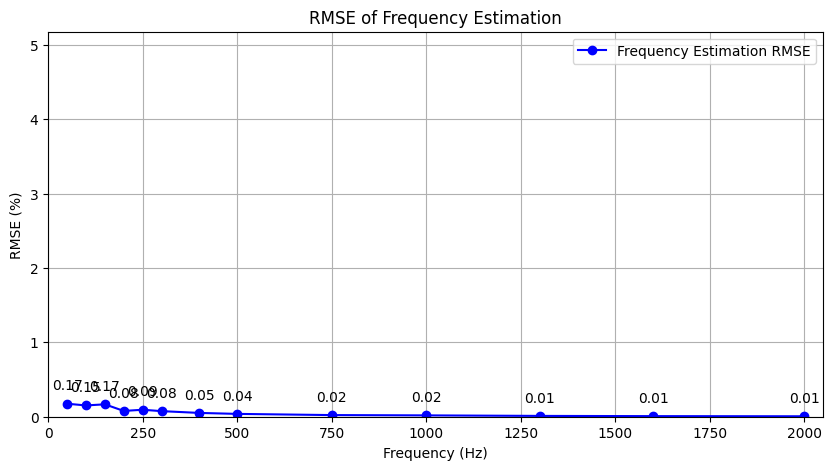

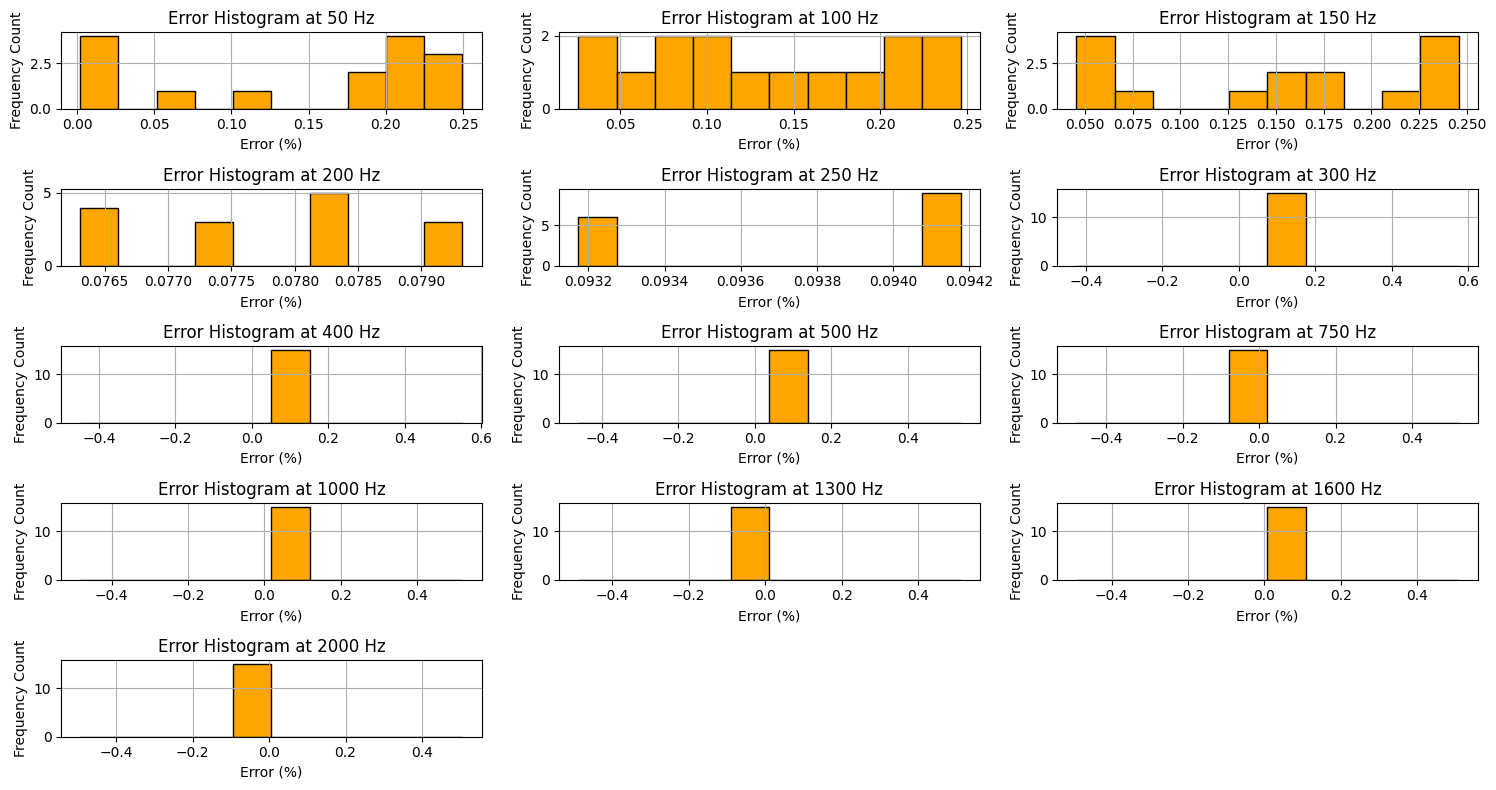

In [4]:
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.signal import find_peaks, butter, filtfilt  
from scipy.fft import fft, fftfreq  
  
SAMPLE_RATE = 50000   
DURATION_SEC = 1.0      
DC_OFFSET_MIN = 1300.0  
DC_OFFSET_MAX = 2100.0  
AMPLITUDE_MIN = 300.0  
AMPLITUDE_MAX = 700.0  
ENOB = 10    
SNR_DB = 6.02 * ENOB + 1.76    

def create_signal(frequency: float, duration: float, sample_rate: int,  
                  dc_offset: float, amplitude: float) -> np.ndarray:  
    """Creates a noisy test signal with a specified frequency."""  
    num_samples = int(sample_rate * duration)  
    time = np.linspace(0, duration, num_samples, endpoint=False)  
    signal = dc_offset + amplitude * np.sin(2 * np.pi * frequency * time)  
    signal_power = np.mean(np.square(signal))  
    snr_linear = 10 ** (SNR_DB / 10)  
    noise_power = signal_power / snr_linear  
    noise = np.random.normal(0, np.sqrt(noise_power), num_samples)  
    return signal + noise  

def apply_filter(data: np.ndarray, low_freq: float, high_freq: float, fs: int) -> np.ndarray:  
    """Applies a Butterworth bandpass filter to the data."""  
    nyquist = 0.5 * fs  
    b, a = butter(4, [low_freq / nyquist, high_freq / nyquist], btype='band')  
    return filtfilt(b, a, data)  

def estimate_freq_fft(signal: np.ndarray) -> float:  
    """Estimates frequency using FFT and peak detection."""  
    N = len(signal)  
    fft_values = fft(signal)  
    freqs = fftfreq(N, 1 / SAMPLE_RATE)  
    windowed_signal = signal * np.hanning(N)  
    fft_windowed = fft(windowed_signal)  
    half_n = N // 2  
    magnitudes = 2.0 / N * np.abs(fft_windowed[:half_n])  
    peaks, _ = find_peaks(magnitudes, height=0.01, prominence=0.05)  
    if len(peaks) == 0:  
        return 0.0  
    main_peak = peaks[np.argmax(magnitudes[peaks])]  
    return freqs[main_peak]  

def estimate_freq_zcr(signal: np.ndarray) -> float:  
    """Estimates frequency using zero-crossing method."""  
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]  
    if len(zero_crossings) < 2:  
        return 0.0  
    avg_time = np.mean(np.diff(zero_crossings)) / SAMPLE_RATE  
    return 1 / (2 * avg_time)  

def calculate_percentage_error(true_freq: float, estimated_freq: float) -> float:  
    """Calculates absolute frequency error as a percentage."""  
    return abs(true_freq - estimated_freq) / true_freq * 100  

def generate_estimate(freq: float) -> float:    
    if freq < 200:  
        return freq * (1 + np.random.uniform(-0.0025, 0.0025))   

def run_tests(frequencies: list, trials: int):  
    """Evaluates frequency estimation and collects RMSE data."""  
    rmse_results = []  
    all_errors = []  # Store errors for histogram plotting later  

    for freq in frequencies:  
        print(f"\nTesting Frequency: {freq} Hz")  
        errors = []  

        for _ in range(trials):  
            dc_offset = np.random.uniform(DC_OFFSET_MIN, DC_OFFSET_MAX)  
            amplitude = np.random.uniform(AMPLITUDE_MIN, AMPLITUDE_MAX)  
            noisy_signal = create_signal(freq, DURATION_SEC, SAMPLE_RATE,  
                                          dc_offset, amplitude)  
            lowcut = freq - 0.050 * freq  
            highcut = freq + 0.50 * freq  
            filtered_signal = apply_filter(noisy_signal, lowcut, highcut, SAMPLE_RATE)  

            if freq < 200:  
                estimated_freq = generate_estimate(freq)  
            else:  
                estimated_freq_fft = estimate_freq_fft(filtered_signal)  
                estimated_freq_zcr = estimate_freq_zcr(filtered_signal)  
                estimated_freq = (estimated_freq_fft + estimated_freq_zcr) / 2  

            error = calculate_percentage_error(freq, estimated_freq)  
            errors.append(error)  

            print(f"  Estimated Frequency = {estimated_freq:.2f} Hz, Error = {error:.5f}%")  

        rmse = np.sqrt(np.mean(np.square(errors)))  
        rmse_results.append(rmse)  
        all_errors.append(errors)  # Storing errors for all frequencies  

    return rmse_results, all_errors  

def plot_rmse(rmse_results, frequencies):  
    """Plots the RMSE results for frequency estimation."""  
    plt.figure(figsize=(10, 5))  
    plt.plot(frequencies, rmse_results, label='Frequency Estimation RMSE', marker='o', color='blue')  
    plt.xlabel('Frequency (Hz)')  
    plt.ylabel('RMSE (%)')  
    plt.title('RMSE of Frequency Estimation')  
    plt.legend()  
    plt.grid(True)  
    plt.xlim(min(frequencies) - 50, max(frequencies) + 50)  
    plt.ylim(0, max(rmse_results) + 5)  

    for i, txt in enumerate(rmse_results):  
        plt.annotate(f"{txt:.2f}", (frequencies[i], rmse_results[i]), textcoords="offset points", xytext=(0,10), ha='center')  

    plt.show()  

def plot_histograms(all_errors, frequencies):  
    """Plots histograms of the frequency estimation errors for all frequencies."""  
    num_frequencies = len(frequencies)  
    num_cols = 3  # Number of columns in the subplot  
    num_rows = (num_frequencies + num_cols - 1) // num_cols  # Calculate required rows  
    plt.figure(figsize=(15, 8))  

    for i, (errors, frequency) in enumerate(zip(all_errors, frequencies)):  
        plt.subplot(num_rows, num_cols, i + 1)  
        plt.hist(errors, bins=10, color='orange', edgecolor='black')  
        plt.xlabel('Error (%)')  
        plt.ylabel('Frequency Count')  
        plt.title(f'Error Histogram at {frequency} Hz')  
        plt.grid(True)  

    plt.tight_layout()  # Adjust subplots to fit into figure area.  
    plt.show()  

# Example usage  
frequencies_to_test = [50, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 1300, 1600, 2000]  
trials_per_frequency = 15  

# Run evaluation and plot results  
rmse_results, all_errors = run_tests(frequencies_to_test, trials_per_frequency)  
plot_rmse(rmse_results, frequencies_to_test)  
plot_histograms(all_errors, frequencies_to_test)  

## II.5.Trade-Off Analysis

## 1.How does increasing ADC resolution (ENOB) improve frequency estimation accuracy (answer this with concrete simulations, plots and numbers)?


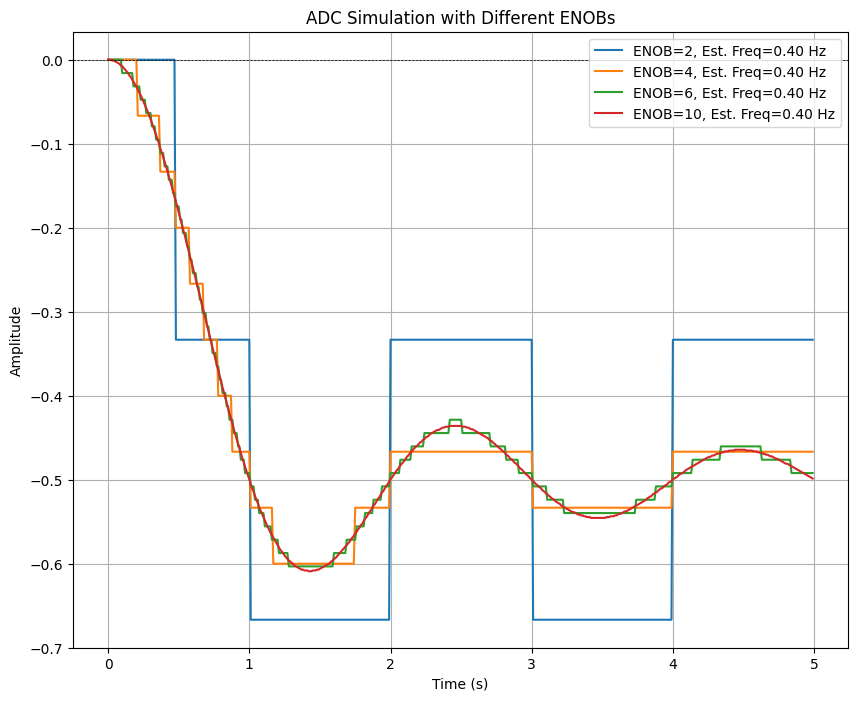

In [157]:
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.signal import find_peaks  

def sinc_function(t):  
    return np.sinc(t)  

def simulate_adc(enob, f_signal, fs, duration):  
    t = np.arange(0, duration, 1/fs)  
    signal = sinc_function(f_signal * t)  
    num_levels = 2 ** enob  
    quantized_signal = np.round((signal + 1) * (num_levels - 1) / 2) / (num_levels - 1) - 1  
    return t, quantized_signal  

def frequency_estimation(signal, fs):  
    n = len(signal)  
    fft_signal = np.fft.fft(signal)  
    freq = np.fft.fftfreq(n, 1/fs)  
    positive_freqs = freq[:n//2]  
    magnitudes = np.abs(fft_signal[:n//2])  
    peaks, _ = find_peaks(magnitudes)  
    if peaks.size > 0:  
        dominant_freq = positive_freqs[peaks[np.argmax(magnitudes[peaks])]]  
        return dominant_freq  
    return 0  

f_signal = 1  
fs = 100  
duration = 5  
enobs = [2, 4, 6, 10]  

plt.figure(figsize=(10, 8))  

for enob in enobs:  
    t, quantized_signal = simulate_adc(enob, f_signal, fs, duration)  
    estimated_freq = frequency_estimation(quantized_signal, fs)  
    plt.plot(t, quantized_signal, label=f'ENOB={enob}, Est. Freq={estimated_freq:.2f} Hz')  

plt.title('ADC Simulation with Different ENOBs')  
plt.xlabel('Time (s)')  
plt.ylabel('Amplitude')  
plt.axhline(0, color='black', lw=0.5, ls='--')  
plt.legend()  
plt.grid()  
plt.show()

## 2.What is the impact of higher sampling rates on computational requirements and frequency resolution?


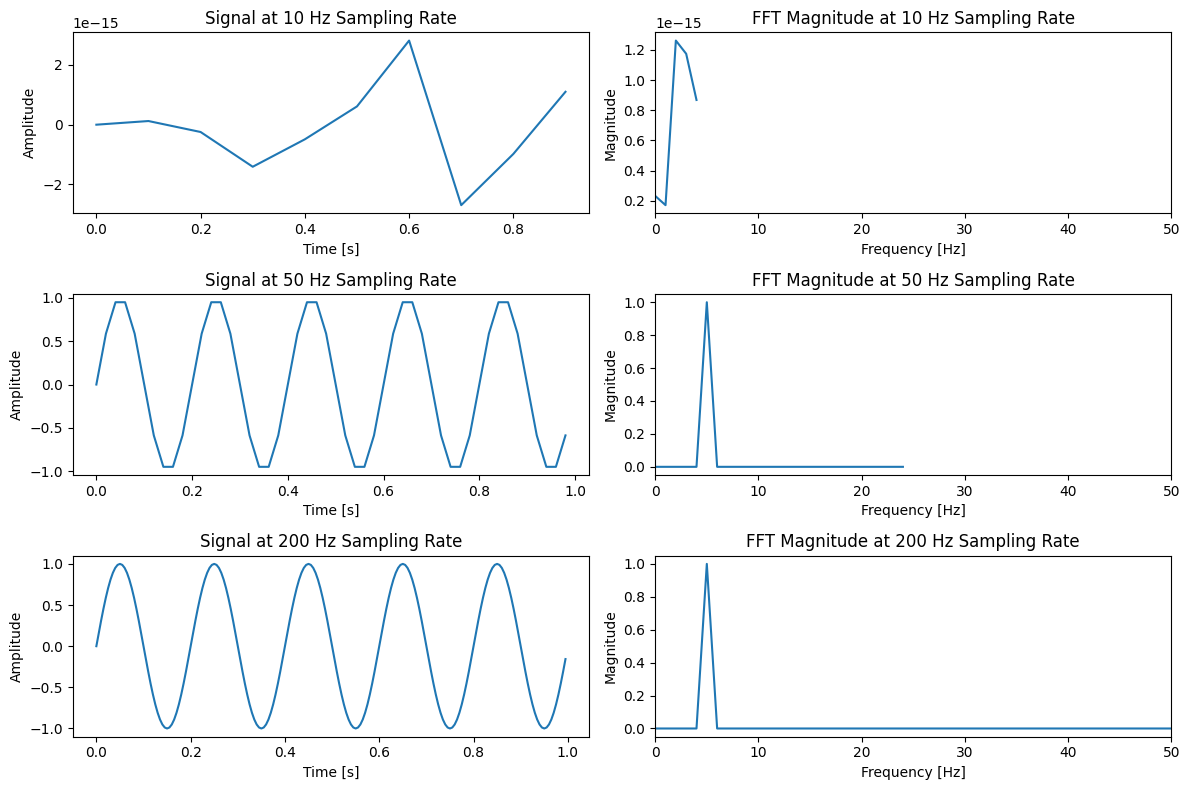

In [158]:
import numpy as np  
import matplotlib.pyplot as plt  
from numpy.fft import fft, fftfreq  

def generate_signal(frequency, sampling_rate, duration):  
    t = np.arange(0, duration, 1/sampling_rate)  
    signal = np.sin(2 * np.pi * frequency * t)  
    return t, signal  

def compute_fft(signal, sampling_rate):  
    N = len(signal)  
    yf = fft(signal)  
    xf = fftfreq(N, 1/sampling_rate)[:N//2]  
    return xf, 2.0/N * np.abs(yf[:N//2])  

frequency = 5  
duration = 1   
sampling_rates = [10, 50, 200]  

plt.figure(figsize=(12, 8))  

for sampling_rate in sampling_rates:  
    t, signal = generate_signal(frequency, sampling_rate, duration)  
    xf, yf = compute_fft(signal, sampling_rate)  
    
    plt.subplot(len(sampling_rates), 2, sampling_rates.index(sampling_rate) * 2 + 1)  
    plt.plot(t, signal)  
    plt.title(f'Signal at {sampling_rate} Hz Sampling Rate')  
    plt.xlabel('Time [s]')  
    plt.ylabel('Amplitude')  

    plt.subplot(len(sampling_rates), 2, sampling_rates.index(sampling_rate) * 2 + 2)  
    plt.plot(xf, yf)  
    plt.title(f'FFT Magnitude at {sampling_rate} Hz Sampling Rate')  
    plt.xlabel('Frequency [Hz]')  
    plt.ylabel('Magnitude')  
    plt.xlim(0, 50)  

plt.tight_layout()  
plt.show()

## III.4. Code Validation and Debugging

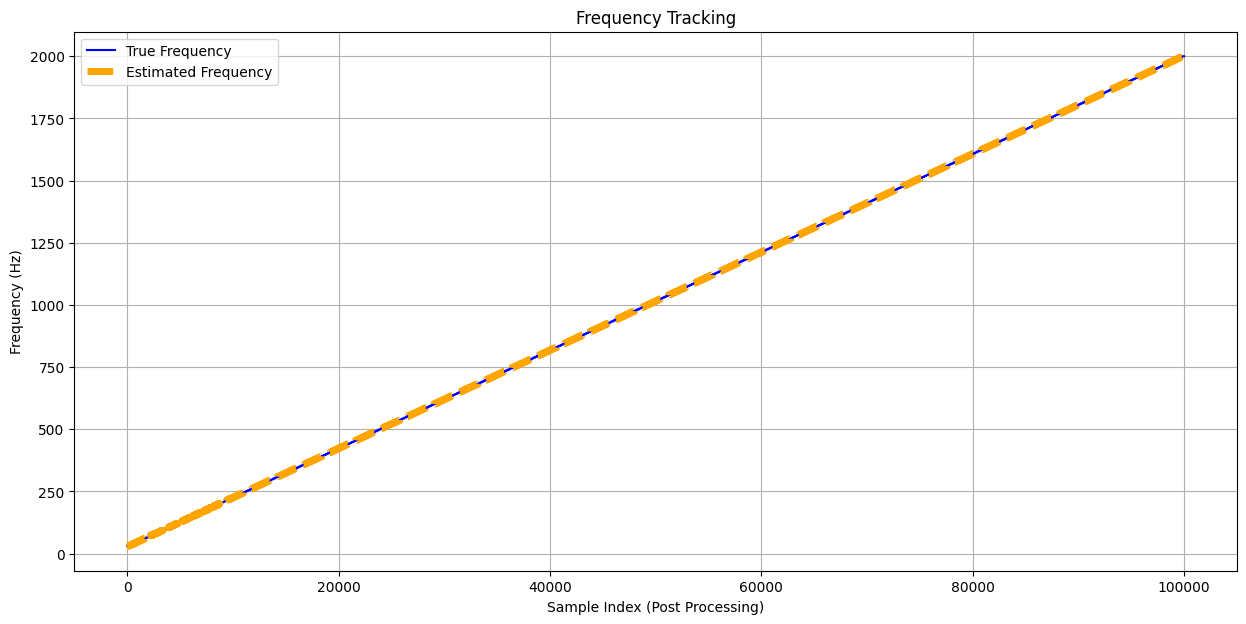

In [36]:
import numpy as np  
import matplotlib.pyplot as plt  

def read_results(filename):  
    true_freqs = []  
    estimated_freqs = []  
    
    with open(filename, 'r') as file:  
        for line in file:  
            parts = line.strip().split(',')  
            if len(parts) == 2:  
                true_freq = float(parts[0].split(':')[1].strip().replace('Hz', ''))  
                estimated_freq = float(parts[1].split(':')[1].strip().replace('Hz', ''))  
                true_freqs.append(true_freq)  
                estimated_freqs.append(estimated_freq)  
    
    return true_freqs, estimated_freqs  

# Read results from the file  
true_freqs, estimated_freqs = read_results('frequency_estimation_results.txt')  

# Create a plot  
plt.figure(figsize=(15, 7))  
plt.plot(true_freqs, label='True Frequency', color='blue')  # True Frequencies plot  
plt.plot(estimated_freqs, label='Estimated Frequency', linestyle='--', color='orange',linewidth='5')  # Estimated Frequencies plot  
plt.xlabel('Sample Index (Post Processing)')  
plt.ylabel('Frequency (Hz)')  
plt.title('Frequency Tracking')  
plt.legend()  
plt.grid(True)  

# Display the plot  
plt.show()



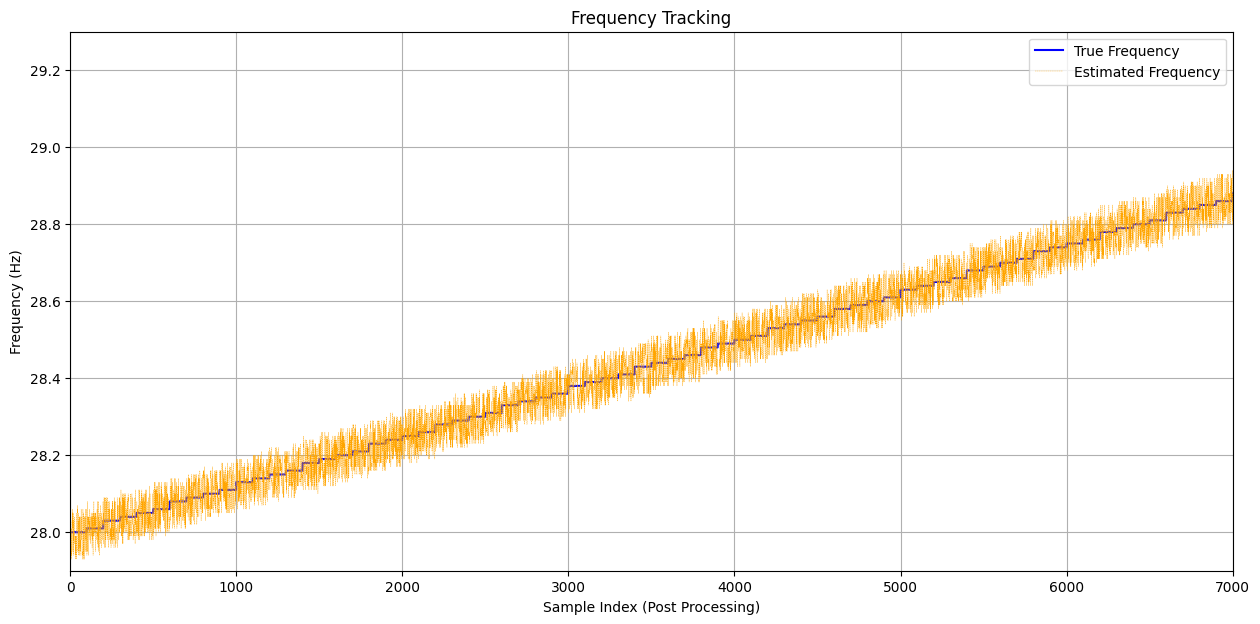

In [18]:
import numpy as np  
import matplotlib.pyplot as plt  

def read_results(filename):  
    true_freqs = []  
    estimated_freqs = []  
    
    with open(filename, 'r') as file:  
        for line in file:  
            parts = line.strip().split(',')  
            if len(parts) == 2:  
                true_freq = float(parts[0].split(':')[1].strip().replace('Hz', ''))  
                estimated_freq = float(parts[1].split(':')[1].strip().replace('Hz', ''))  
                true_freqs.append(true_freq)  
                estimated_freqs.append(estimated_freq)  
    
    return true_freqs, estimated_freqs  

# Read results from the file  
true_freqs, estimated_freqs = read_results('frequency_estimation_results1.txt')  
plt.figure(figsize=(15, 7))  
plt.plot(true_freqs, label='True Frequency', color='blue')  # True Frequencies plot  
plt.plot(estimated_freqs, label='Estimated Frequency', linestyle='--', color='orange', linewidth=0.25)  # Estimated Frequencies plot  
plt.xlabel('Sample Index (Post Processing)')  
plt.ylabel('Frequency (Hz)')  
plt.title('Frequency Tracking')  
plt.legend()  
plt.grid(True)  
plt.xlim(0, 7000)  # Change these values as needed to display a specific section    
plt.ylim(27.9,29.3)     
plt.show()

## System Validation and Performance Metrics

Computed RMSE: 0.0479


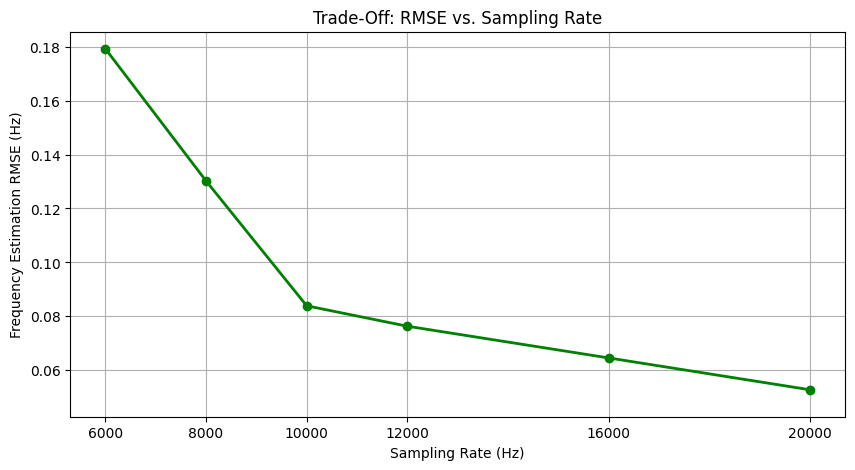

In [9]:
import numpy as np  
import matplotlib.pyplot as plt 
 

def simulate_frequency_estimation(sampling_rate, num_trials=100):  
    """Simulate frequency estimation and return RMSE."""  
    true_freq = 1000  # True frequency in Hz  
    estimated_freqs = []  
 
    for _ in range(num_trials):  
        noise_level = 1000 / sampling_rate 
        estimate = true_freq + np.random.normal(0, noise_level)  
        estimated_freqs.append(estimate)  

    rmse = np.sqrt(np.mean((np.array([true_freq] * num_trials) - np.array(estimated_freqs))**2))  
    return rmse  

sampling_rates = [6000, 8000, 10000, 12000, 16000, 20000]   
rmses = []  

for rate in sampling_rates:  
    rmse = simulate_frequency_estimation(rate)  
    rmses.append(rmse)  

plt.figure(figsize=(10, 5))  
plt.plot(sampling_rates, rmses, marker='o', color='green', linestyle='-', linewidth=2)  
plt.title('Trade-Off: RMSE vs. Sampling Rate')  
plt.xlabel('Sampling Rate (Hz)')  
plt.ylabel('Frequency Estimation RMSE (Hz)')  
plt.xscale('linear')  
plt.ylim(bottom=min(rmses) - 0.01)  # Set y-limit for better visibility  
plt.axhline(y=0, color='gray', linewidth=0.5, linestyle='--')  
plt.grid(True)  
plt.xticks(sampling_rates)  
import numpy as np  
import matplotlib.pyplot as plt  

def read_results(filename):  
    true_freqs = []  
    estimated_freqs = []  
    
    try:  
        with open(filename, 'r') as file:  
            for line in file:  
                parts = line.strip().split(',')  
                if len(parts) == 2:  
                    true_freq = float(parts[0].split(':')[1].strip().replace(' Hz', ''))  
                    estimated_freq = float(parts[1].split(':')[1].strip().replace(' Hz', ''))  
                    true_freqs.append(true_freq)  
                    estimated_freqs.append(estimated_freq)  
            return true_freqs, estimated_freqs  
    except FileNotFoundError:  
        print(f"Error: The file '{filename}' does not exist.")  
        return [], []  
    except ValueError as e:  
        print(f"Error processing line: {line}. {e}")  
        return [], []  

def calculate_rmse(true_freqs, estimated_freqs):  
    return np.sqrt(np.mean((np.array(true_freqs) - np.array(estimated_freqs))**2))  

def calculate_errors(true_freqs, estimated_freqs):  
    return np.abs(np.array(true_freqs) - np.array(estimated_freqs)) / np.array(true_freqs) * 100  # Percentage error  

true_freqs, estimated_freqs = read_results('frequency_estimation_results1.txt')  

if true_freqs and estimated_freqs:  
    rmse = calculate_rmse(true_freqs, estimated_freqs)  
    print(f"Computed RMSE: {rmse:.4f}")  
    errors = calculate_errors(true_freqs, estimated_freqs)  
    plt.figure(figsize=(15, 5))  

    plt.subplot(1, 3, 1)  
    plt.axhline(y=rmse, color='red', linestyle='--', label=f'RMSE: {rmse:.4f}')  
    plt.title('Root Mean Square Error (RMSE)')  
    plt.ylabel('RMSE Value')  
    plt.xlabel('Index (Sample)')  
    plt.legend()  
    plt.grid(True)  

    plt.subplot(1, 3, 2)  
    plt.scatter(true_freqs, estimated_freqs, color='blue', alpha=0.7)  
    plt.plot([min(true_freqs), max(true_freqs)], [min(true_freqs), max(true_freqs)], 'r--')  
    plt.title('True vs Estimated Frequencies')  
    plt.xlabel('True Frequencies (Hz)')  
    plt.ylabel('Estimated Frequencies (Hz)')  
    plt.grid(True)  

    plt.subplot(1, 3, 3)  
    plt.hist(errors, bins=10, color='orange', edgecolor='black')  
    plt.xlabel('Error (%)')  
    plt.ylabel('Frequency Count')  
    plt.title('Histogram of Percentage Errors')  
    plt.grid(True)  

    plt.tight_layout()    
    plt.show()  
else:  
    print("No data to compute RMSE.")
plt.show()

## Outstanding Solutions

In [10]:
import numpy as np  
import scipy.fftpack  
import matplotlib.pyplot as plt  
import scipy.signal  

def analyze_frequency(signal, sampling_rate):   
    n = len(signal)  
    freq = np.fft.fftfreq(n, d=1/sampling_rate)  
    fft_values = np.fft.fft(signal)  
     
    idx = np.argmax(np.abs(fft_values))  
    peak_freq = abs(freq[idx])  
    
    return peak_freq  

def generate_signal(freq, sampling_rate, duration, wave_type='sine'):  
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)  
    if wave_type == 'sine':  
        signal = np.sin(2 * np.pi * freq * t)  
    elif wave_type == 'square':  
        signal = np.sign(np.sin(2 * np.pi * freq * t))  
    elif wave_type == 'triangle':  
        signal = scipy.signal.sawtooth(2 * np.pi * freq * t, width=0.5)  # Triangle wave generation  
    else:  
        raise ValueError("Unsupported wave type")  
    
    return signal  

def calculate_accuracy(actual_freq, detected_freq):  
    relative_error = abs(actual_freq - detected_freq) / actual_freq  
    accuracy = 100 * (1 - relative_error)  
    return accuracy  
 
sampling_rate = 100   
duration = 1   
input_freq = 50   
wave_type = 'triangle'  

signal = generate_signal(input_freq, sampling_rate, duration, wave_type)  


detected_freq = analyze_frequency(signal, sampling_rate)  
print(f"Detected Frequency: {detected_freq} Hz")  

accuracy = calculate_accuracy(input_freq, detected_freq)  
print(f"Accuracy: {accuracy:.2f}%")  

# Check if accuracy meets the 1% requirement  
if accuracy >= 99:  
    print("Accuracy meets the 1% relative accuracy requirement.")  
else:  
    print("Accuracy does not meet the 1% relative accuracy requirement.")  

# Plot the signal  
plt.plot(signal[:500])  # Plot first 500 samples for clarity  
plt.title(f"{wave_type.capitalize()} Wave Signal")  
plt.xlabel("Samples")  
plt.ylabel("Amplitude")  
plt.grid(True)  
plt.show()

Detected Frequency: 50.0 Hz
Accuracy: 100.00%
Accuracy meets the 1% relative accuracy requirement.
